# ML Pipeline Preparation

## 1. Import libraries and load data from database.
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pickle

In [2]:
# nlp libraries
import nltk
# nltk.download() # run only once

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
# scikit-learn libraries
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

In [2]:
#in case that autocomplete does not work on the notebook
%config Completer.use_jedi = False

In [3]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('messages', engine)

In [4]:
# Last five average values (ascending order)
df.describe().loc['mean'].sort_values().tail(5)

direct_report          0.193591
weather_related        0.278352
aid_related            0.414267
related                0.766470
id                 15224.871333
Name: mean, dtype: float64

In [5]:
# First 5 average values 
df.describe().loc['mean'].sort_values().head(5)

child_alone    0.000000
offer          0.004501
shops          0.004578
tools          0.006065
fire           0.010757
Name: mean, dtype: float64

The above code gives the mean of binary values for each category. If the proportion between 0 and 1 are well balanced, it will give 0.5. Except for `related` and `aid-related` columns, all the other categories are quite biased to 0, which is worth noting.

Coming from the future, some classifier algorithms give errors if they find a feature with only one class, which is the case for `child_alone`. Therefore we will drop the column.

In [14]:
# Dropping 'child_alone' feature
df.drop(columns='child_alone', inplace=True)

For modeling, extracting predictor variable X and response variable Y.

- Predictor variable X : english-translate messages, which will need some preprocessing

- Response variable Y : matrix of 35 catogories (after `child_alone` columns was dropped) and corresponding binary values.

In [15]:
X = df['message'] 
Y = df.iloc[:, 4:]

In [16]:
# Checking if predictor variable X contains 35 categories
# Ture if no error pops up
assert Y.shape[1] == 35

## 2. Write a tokenization function to process your text data

In [17]:
def tokenize(text):
    ''' Split text into tokens follwed by preprocessing processes to
    lowercase the text, remove stopwords and remove puntuations. 
    Then return lemmatized tokens.
    
    Arguments:
        text <-- disaster response message
    Output : 
        tokens    
    '''
                
    

    tokens = [
        word.strip() for word in word_tokenize(text.lower())
        if (word not in stopwords.words('english') and  # not stopword
            word.isalnum()) # is alpha-numeric word           
    ]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer() # instantiate a lemmatizer
    lemmed = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmed

In [18]:
# Testing the function 
sample_texts = X[:5]

for text in sample_texts :
    print(f'Original text  : {text}')
    print(f'Tokenized text : {tokenize(text)}')
    print()

Original text  : Weather update - a cold front from Cuba that could pass over Haiti
Tokenized text : ['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']

Original text  : Is the Hurricane over or is it not over
Tokenized text : ['hurricane']

Original text  : Looking for someone but no name
Tokenized text : ['looking', 'someone', 'name']

Original text  : UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
Tokenized text : ['un', 'report', 'leogane', 'destroyed', 'hospital', 'croix', 'functioning', 'need', 'supply', 'desperately']

Original text  : says: west side of Haiti, rest of the country today and tonight
Tokenized text : ['say', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight']



## 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [19]:
pipeline_test = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),    
    ('clf', MultiOutputClassifier(LogisticRegression()))
])

## 4. Train pipeline

In [20]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

In [21]:
# Fitting the model to the train sets (takes some minutes)
pipeline_test.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fb0af4bfdc0>)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=LogisticRegression()))])

#### Debugging : 

`ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0`

will return when data contains only one class, which is the case for `child_alone` column. There the column needs to be removed.

## 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### Prediction on X_test

In [22]:
# Predict on X_test
Y_pred = pipeline_test.predict(X_test)

### Evaluating with metrics

In [27]:
# Printing classification report
print('Accuracy score: ', accuracy_score(Y_test.values, Y_pred), end='\n\n')
print(classification_report(Y_test.values, Y_pred, target_names=Y.columns.values))

Accuracy score:  0.2863899908452853

                        precision    recall  f1-score   support

               related       0.85      0.95      0.90      5046
               request       0.80      0.51      0.63      1129
                 offer       0.00      0.00      0.00        34
           aid_related       0.77      0.68      0.72      2714
          medical_help       0.65      0.18      0.28       543
      medical_products       0.81      0.18      0.29       335
     search_and_rescue       0.88      0.04      0.07       190
              security       0.00      0.00      0.00       131
              military       0.62      0.12      0.20       215
                 water       0.79      0.49      0.61       388
                  food       0.82      0.56      0.66       710
               shelter       0.81      0.43      0.56       550
              clothing       0.82      0.28      0.42       100
                 money       0.62      0.05      0.10       150
  

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

Note that `random_state=11` is set when splitting train and test sets, and the results may be different across different randome states.  

Accuracy score is extremely low, and the averaged scores (micro, maro and weighted) did not show high scores. Given `macro avg`, calculates metrics for each label and then find the average, the lower f1 macro avg score is attributed to some zero f1 scores, especially from cateogories with relatively scarce data, i.e. 'offer', 'child_alone', missing people', etc. 

<font color="orangered">Due to label imbalances, <strong>macro avg</strong> is not a good solution (according to scikit-learn's documentation at the link below) and we will adopt <strong>micro avg</strong> and <strong>weighted avg</strong> for model evaluation, hereafter.</font>

**Terminology for the scores can be found in detail** at the link [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support).

### [EXTRA] Zero F1 score
The zero f1 scores are due to `zero-divison` issues. Let's inspect.

In [59]:
# Return the report in dictionary
clf_result = classification_report(Y_test.values, Y_pred, target_names=Y.columns.values, output_dict=True)

In [63]:
# Construct a list of columns with zero f1-score
zero_div_cols = []

for key, value in clf_result.items() : 
    if value['f1-score'] == 0 : 
        zero_div_cols.append(key)

In [64]:
# Y_pred is array --> convert to a dataframe
Y_pred_df = pd.DataFrame(Y_pred, columns=Y.columns.values)

In [65]:
print('Confusion matrix for zero f1 scored categories', end='\n\n')
for col in zero_div_cols : 
    print(f' <{col}> category')
    print(confusion_matrix(Y_test[col], Y_pred_df[col], labels=[0, 1]), end='\n\n')

Confusion matrix for zero f1 scored categories

 <offer> category
[[6520    0]
 [  34    0]]

 <security> category
[[6423    0]
 [ 131    0]]

 <missing_people> category
[[6459    0]
 [  95    0]]

 <tools> category
[[6500    0]
 [  54    0]]

 <hospitals> category
[[6474    0]
 [  80    0]]

 <shops> category
[[6520    0]
 [  34    0]]

 <aid_centers> category
[[6473    0]
 [  81    0]]



True Positive(TP) is zero for the zero-division categories, and there are recall, precision and then f1-scores return zero.

- Recall : TP / (TP + FN)
- Precision : TP / (TP + FP)
- F1 score : 2 x (recall x precision) / (recall + precision)

Source : Wikipedia at the link [here](https://en.wikipedia.org/wiki/Confusion_matrix).

### [EXTRA] Inspecting True Positives
Using the original dataset, `df`

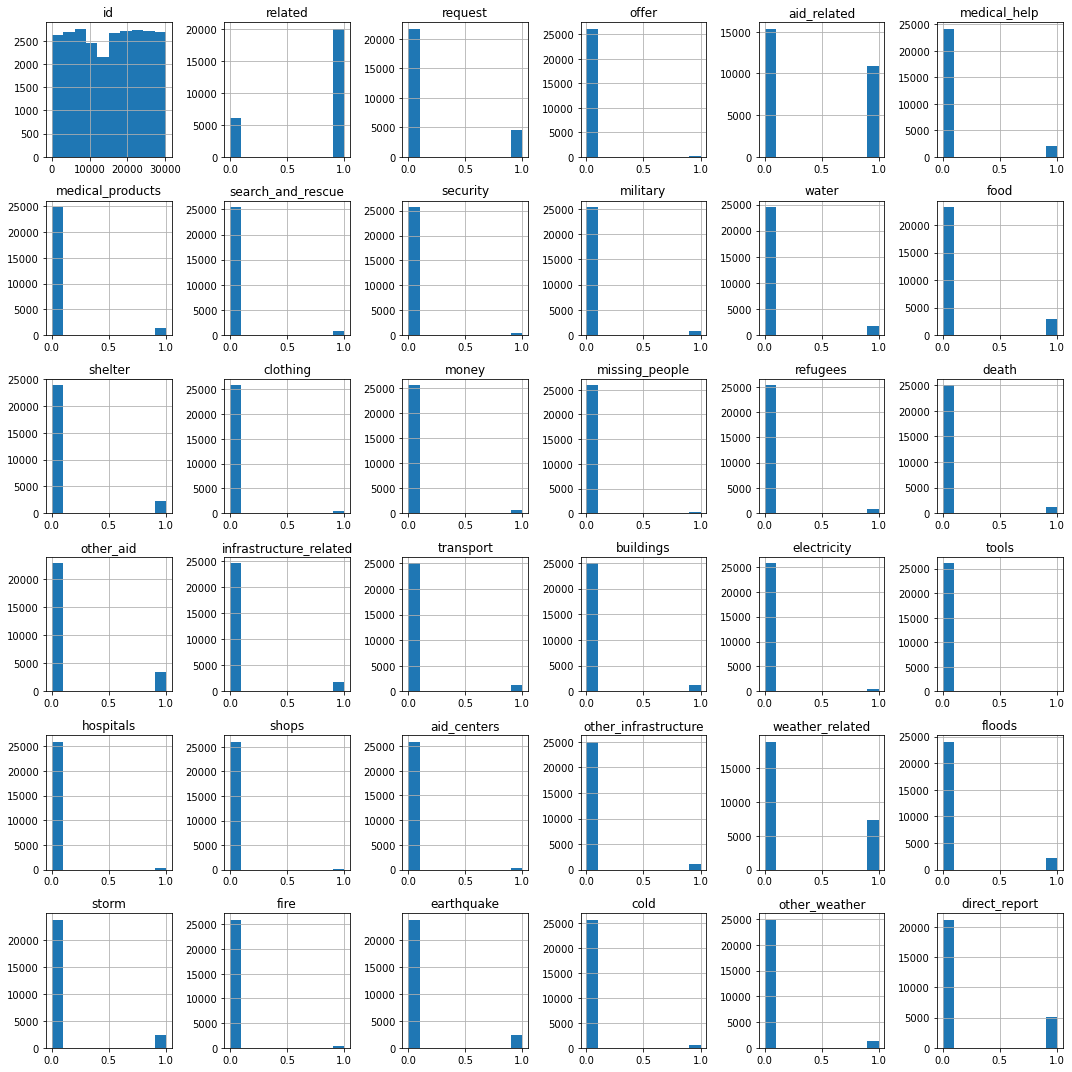

In [66]:
df.hist(figsize=(15,15));
plt.tight_layout()
plt.show()

As seen earlier in the original dataframe `df`, many categories have imblanced proportion of binary values.  A majority of categories does not have enough set of positive/true values(represented as 1), especially for the categories that reported zero-division / zero true positive.

### Function for model evaluation

In [28]:
def evaluate_model(y_test, y_pred, expand=False) : 
    ''' Evaluate the performance of classification model.
    Metrics include accuracy score, and micro and weighted average
    of recall, precision and f1 score -- macro average is not used 
    due to feature imblances and weighted average to supplment instead
        
    Arguments:
        y_test : target variable of the test set
        y_pred : predicted target variable 
        expand : default to False. If True, expand to the full report
        that includes scores for individual label and aggregated.
   
    Output:
        To print evaluated scores     
    '''
    
    # To block zero-division error messages 
    # which we already know that exists     
    import warnings
    warnings.filterwarnings('ignore')

    # Printing scores
    accuracy =  accuracy_score(np.array(y_test), np.array(y_pred)) * 100
    print(f'Accuracy score: {accuracy:.2f}%', end='\n\n')
    print(f'Classification score:')
    
    if expand : 
        clf_report = classification_report(np.array(y_test), np.array(y_pred), 
                                           target_names=y_test.columns.values, 
                                           output_dict=False)
        print(clf_report)

    else : 
        clf_report = classification_report(np.array(y_test), np.array(y_pred),
                                           target_names=y_test.columns.values, 
                                           output_dict=True)
        
        
        df = pd.DataFrame(clf_report)
        
        
        print(df[['micro avg', 'weighted avg']].T)
        

In [29]:
evaluate_model(Y_test, Y_pred, expand=False)

Accuracy score: 28.64%

Classification score:
              precision    recall  f1-score  support
micro avg      0.811769  0.536515  0.646045  20827.0
weighted avg   0.756561  0.536515  0.585830  20827.0


## 6. Improve your model
Use grid search to find better parameters. 

In [134]:
# Load the same pipeline_test again
pipeline_test = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression()))
])

In [135]:
params = {
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'clf__estimator__C': (1, 100, 200) # C=100 --> less regularized
}

scorer = make_scorer(f1_score, average='micro') # average of all labels
cv = GridSearchCV(pipeline_test, params, verbose=3, scoring=scorer, n_jobs=1, cv=2)

In [136]:
cv.fit(X_train, Y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=True, score=0.626, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=True, score=0.627, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=False, score=0.642, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=False 
[CV]  clf__estimator__C=1, tfidf__smooth_idf=True, tfidf__use_idf=False, score=0.641, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=True 
[CV]  clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=True, score=0.625, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=True 
[CV]  clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=True, score=0.626, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=False 
[CV]  clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=False, score=0.642, total= 1.1min
[CV] clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=False 
[CV]  clf__estimator__C=1, tfidf__smooth_idf=False, tfidf__use_idf=False, score=0.641, total= 1.1min
[CV] clf__estimator__C=100, tfidf__s

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 28.3min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7ffabe94d8b0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=LogisticRegression()))]),
             n_jobs=1,
             param_grid={'clf__estimator__C': (1, 100, 200),
                         'tfidf__smooth_idf': (True, False),
                         'tfidf__use_idf': (True, False)},
             scoring=make_scorer(f1_score, average=micro), verbose=3)

Due to significantly long time that takes for grid search, number of different parameters have been reduced to 4 and cross validation reduced to 2-fold from the default 5-fold. 

**Objective**
Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

## 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

In [137]:
cv.best_params_, cv.best_score_

({'clf__estimator__C': 100,
  'tfidf__smooth_idf': True,
  'tfidf__use_idf': False},
 0.6437199409482793)

The above grid search did not really improved the micro average f1-score (0.646045 -> 0.643719). 

Let's fit the improved model to see the performance in detail.

In [30]:
# Constructing the second pipeline
pipeline_test2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer(use_idf=False, smooth_idf=True)),
    ('clf', MultiOutputClassifier(LogisticRegression(C=100)))
])

In [31]:
# Fit the second test pipeline
pipeline_test2.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fb0af4bfdc0>)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=100)))])

In [32]:
# Predict on X_test
Y_pred_test2 = pipeline_test2.predict(X_test)

In [33]:
evaluate_model(Y_test, Y_pred_test2, expand=False)

Accuracy score: 24.98%

Classification score:
              precision  recall  f1-score  support
micro avg      0.711850  0.5913  0.645999  20827.0
weighted avg   0.681031  0.5913  0.625568  20827.0


### Result comparion

The accuracy score perform poorer with the parameters found with grid search. When it comes to F1 score, micro average slightly got worsen but weighted avg improved. 


| Scores          | Test1(Default)   | Test2(Grid search)|
| --------------- |:-----------------: | -----------------:|
| Accuracy score  | 28.64%             | 24.98%            |
| F1 micro avg    | 0.646045           | 0.645999          |
| F1 weighted avg | 0.585830           | 0.625568          |

### Save the test model 2 with pickle

In [34]:
filename = 'test_models/classifier_test2.pkl'
pickle.dump(pipeline_test2, open(filename, 'wb'))

## 8. Try improving your model further. 
* try other machine learning algorithms
* ~~add other features besides the TF-IDF~~ (not for this project)

### Using LinearSVC classifier

In [151]:
# Create a new test pipeline with LinearSVC()
# Using the same parameters obtained from grid search
pipeline_test3 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer(use_idf=False, smooth_idf=True)),
    ('clf', MultiOutputClassifier(LinearSVC(C=100)))
])

In [152]:
# Fit the test model 3
pipeline_test3.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7ffabe94d8b0>)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultiOutputClassifier(estimator=LinearSVC(C=100)))])

In [153]:
# Run predictions with X_test
Y_pred_test3 = pipeline_test3.predict(X_test)

In [154]:
evaluate_model(Y_test, Y_pred_test3, expand=False)

Accuracy score: 16.36%

Classification score:
              precision    recall  f1-score  support
micro avg      0.576248  0.574063  0.575153  20827.0
weighted avg   0.578357  0.574063  0.575515  20827.0


Both accuracy score and weighted avg got worse than Logistic Regression. This Linear SVC classifier model therefore will not be saved.

Let's try with the last model, `RandomForestClassifer`.

### Using Random Forest classifier

In [35]:
# Create a new test pipeline with RandomForestClassifer()
# RandomForest use different parameters, so set to default
pipeline_test4 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=11)))
])

In [36]:
# Fit the model and run prediction  
# It takes longer than earlier algorithms
pipeline_test4.fit(X_train, Y_train)
Y_pred_test4 = pipeline_test4.predict(X_test)

In [37]:
evaluate_model(Y_test, Y_pred_test4, expand=False)

Accuracy score: 26.73%

Classification score:
              precision    recall  f1-score  support
micro avg      0.814211  0.532578  0.643948  20827.0
weighted avg   0.748592  0.532578  0.571502  20827.0


### Comparison 

The accuracy score improved with Random Forest algorithm when compared to the Logistic Regression model after grid search. In terms of F1 score, micro avg stays at the similar level whereas weighted avg it worse with Random Forest.


| Scores          | Test2 (Grid search)| Test4 (RandomForest)
| --------------- |:-----------------: | -----------------: 
| Accuracy score  | 24.98%             | 26.73%            
| F1 micro avg    | 0.645999           | 0.643948        
| F1 weighted avg | 0.625568           | 0.571502          

### Save the test model 4 with pickle

In [40]:
filename = 'test_models/classifier_test4.pkl'
pickle.dump(pipeline_test4, open(filename, 'wb'))

### Conclusion - by far

RandomForecst Classifer shows not much of improvement although it requires more computing power (is slower). Therefore, the earlier `pipeline_test2` will be used --> Logistic Regression model(c=100).

## 9. Export your model as a pickle file
As `classifier_v1.sav`, the model version 1.

In [161]:
filename = 'test_models/classifier_v1.pkl'
pickle.dump(pipeline_test2, open(filename, 'wb'))

## 10. Create a script --> `train_classifier.py`